# Group 64: A Deep Look Into Mental Health Stigma in the Tech Workplace
<hr>

#### Team Names
- Phoung Ho (A11163125)
- Karen Yanes (A12174748)
- Nayeli Ruiz (A11984057)
- Sanika Moharana (A12321704)
- Alejandro Panduro (A91134536)

## <i>Introduction and Background</i>

Mental health is a global scale challenge confronting our culture. According to The United Nations “at any given time, it is estimated approximately 20% of the adult population have a mental health problem” (Phyllis). This equates to nearly one and a half billion people who encounter mental health issues. Thus, we selected the overarching umbrella topic to be centered on mental health statistics. To further narrow the scope we selected stigmatization amongst employees in the tech industry given it is a potential career path for most of the members of the team.

Currently, mental health is a stigmatized topic of conversation given the “prejudice against people with mental illness” (Corrigan). It’s taboo and few talk about it. With so much at stake– money, investments, reputation and more, workplace stress levels run high in today's high-functioning society. Especially in the growing trends of startup culture, the rigors of working within technology and innovation are presenting increased risk factors and symptoms towards developing conditions such as anxiety or depression. Recently deemed “Silicon Valley’s Secret,” mental health issues are appearing to have a noticeable prevalence amongst entrepreneurs and workers in the technology industry. This heightened pressure and demand for results at rapid pace has normalized an unspoken rule that categorizes these struggles in a negative light. 

<b> Research Question: </b> What are the most important predictors of perceived mental health stigma? 

<b>Hypothesis: </b> We believe stigma will be higher amongst older adults because a study found “more negative attitudes... among those who believed that depression is a sign of personal weakness” (Jang). One assumption for this reason can be due to new studies and the classification of mental health issues as a medical condition like ADHD as opposed to an older perspective of weakness in the character of the individual. Similarly, we hypothesize males will demonstrate more stigma given previous studies showed males have less knowledge of mental health and more stigma given females are twice as much willingness to use mental health services (Chandra).

## <i> Import Libraries and Load the Data </i>

In [4]:
# Data wrangling and analysis
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)


# Data visualization
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
import folium 
import seaborn as sns


# Configure visualizations
%matplotlib inline
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pylab.rcParams['figure.subplot.wspace'] = 0.4
pylab.rcParams['figure.subplot.hspace'] = 0.4
pylab.rcParams['figure.figsize'] = 14, 6
pylab.rcParams['axes.titlesize'] = 22
pylab.rcParams['axes.labelsize'] = 20
pylab.rcParams['xtick.labelsize'] = 16
pylab.rcParams['ytick.labelsize'] = 16
pylab.rcParams['legend.fontsize'] = 16
pylab.rc("axes.spines", top=False, right=False)
sns.set_style('ticks')
palette = ["#1E88E5", "#43A047", "#e53935", "#5E35B1", "#FFB300", "#00ACC1", "#3949AB", "#F4511E"]
sns.set_palette(palette)


# Data modeling
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [5]:
# 2014-15 OSMI survey responses
mental14_df = pd.read_csv('data/mental_health_2014.csv')
# 2016 OSMI survey responses
mental16_df = pd.read_csv('data/mental_health_2016.csv')
# 2016 OSMI survey metadata
mental16_meta_df = pd.read_json('data/mental_health_2016_meta_users.json')
# Conversion from countries to continents
geo_divs = pd.read_csv('data/geo_divs.csv')

## <i> Extract and Merge Timestamps Into 2016 Dataframe </i>

Unlike the 2014-15 survey responses, the survey submission timestamps were provided in a separate json file that also included other metadata such as the user's operating system and browser. Since we want to see if there are any significant changes in mental health stigma across years or perhaps whether users are more likely to respond more negatively at certain hours of the day or day of the week, it is necessary to obtain timestamps for 2016.

In [6]:
mental16_meta_df = pd.DataFrame.from_records(mental16_meta_df.metadata.values)
mental16_meta_df.drop(['browser', 'network_id', 'platform', 'referer'], axis=1, inplace=True)
mental16_df = pd.concat([mental16_meta_df, mental16_df], axis=1)

In [7]:
mental16_relabels = [
    'date_land', 'date_submit', 'user_agent', 'self_employed', 'num_employees', 'tech_comp', 'tech_role',
    'benefits', 'care_options', 'wellness_program', 'emp_help', 'anon', 'med_leave', 'ment_conseq',
    'phys_conseq', 'coworkers', 'supervisors', 'ment_vs_phys', 'obs_conseq', 'ment_med_cov', 'online_help',
    'reveal_clients', 'reveal_clients_neg', 'reveal_workers', 'reveal_workers_neg', 'productivity',
    'productivity_perc', 'prev_emps', 'pe_benefits', 'pe_care_options', 'pe_wellness_program', 'pe_emp_help',
    'pe_anon', 'pe_ment_conseq', 'pe_phys_conseq', 'pe_coworkers', 'pe_supervisors', 'pe_ment_vs_phys',
    'pe_obs_conseq', 'phys_interv', 'phys_interv_why', 'ment_interv', 'ment_interv_why', 'ment_hurt_career',
    'coworkers_neg', 'share_fam', 'bad_event', 'less_another', 'family_history', 'past_disorder',
    'current_disorder', 'yes_condition', 'maybe_condition', 'diagnosis', 'diag_condition', 'treatment',
    'interfere_treated', 'interfere_untreated', 'age', 'gender', 'country_live', 'state_live', 'country_work',
    'state_work', 'job_position', 'remote'
]
mental16_df.columns = mental16_relabels

## <i> Create work_interfere Feature for 2016 </i>

One of the more trickier features to clean was the feature describing how much a responder thought that mental health conditions would interfere with their daily work. One of the issues was that the 2014-15 survey asks for 'If you have a mental health condition, do you feel that it interferes with your work?' while the 2016 survey splits it into two question for cases 'when being treated effectively' or otherwise. Another related issue is that responders will often answer either one of the questions and mark the other as not applicable. While we should be cautious in drawing too much conclusion in later analyses from such a tricky feature, it might yield some interesting insight so we choose to clean it. Here we loop through the interfere_untreated and interfere_treated columns of the 2016 dataframe and choose:
 1. not applicable --> if both columns contains 'not applicable to me'
 2. the column with a value --> if one column contains 'not applicable to me'
 3. the response closest to the average --> if both columns contain values. This is based on how the responses are ordinal.

In [8]:
work_interfere_to_num = {'Not applicable to me': 0, 'Never': 1, 'Rarely': 2, 'Sometimes': 3, 'Often': 4}
num_to_work_interfere = {0: 'Not applicable to me', 1: 'Never', 2: 'Rarely', 3: 'Sometimes', 4: 'Often'}
work_interfere = []

for ind, row in mental16_df[['interfere_untreated', 'interfere_treated']].iterrows():
    # if 'Not applicable' for either column then add the other one that has a value
    row_mapped = row.map(work_interfere_to_num)
    if row_mapped[0] == 0 or row_mapped[1] == 0:
        work_interfere.append(row_mapped.max())
    # else take the average between both columns and randomly round up or down
    else:
        temp_val = row_mapped.mean()
        round_up_down = np.random.randint(0, 2)
        if not temp_val.is_integer():
            if round_up_down == 0:
                temp_val = np.floor(temp_val)
            if round_up_down == 1:
                temp_val = np.ceil(temp_val)
        work_interfere.append(int(temp_val))
work_interfere = pd.Series(work_interfere).map(num_to_work_interfere)

In [9]:
mental16_df['work_interfere'] = work_interfere

## <i> Combine 2014 and 2016 Dataframes </i>

While the 2016 survey has many more features that were not in the 2014-15 survey, we choose to aggregate these datasets based on their common features to yield a larger pool of observations at the cost of not doing analyses on the extra features from the 2016 dataset.

In [10]:
mental14_relabels = [
    'date_submit', 'age', 'gender', 'country_live', 'state_live', 'self_employed', 'family_history', 'treatment',
    'work_interfere', 'num_employees', 'remote', 'tech_comp', 'benefits', 'care_options', 'wellness_program', 
    'emp_help', 'anon', 'med_leave', 'ment_conseq', 'phys_conseq', 'coworkers', 'supervisors', 'ment_interv',
    'phys_interv', 'ment_vs_phys', 'obs_conseq', 'comments' 
]
mental14_df.columns = mental14_relabels

In [11]:
combined_df = pd.concat([mental14_df,mental16_df],join='inner')

In [12]:
combined_df.reset_index(drop=True, inplace=True)

In [13]:
combined_df.shape

(2692, 26)

In [14]:
combined_df.tail()

,date_submit,self_employed,num_employees,tech_comp,benefits,care_options,wellness_program,emp_help,anon,med_leave,ment_conseq,phys_conseq,coworkers,supervisors,ment_vs_phys,obs_conseq,phys_interv,ment_interv,family_history,treatment,age,gender,country_live,state_live,remote,work_interfere
2687,2016-11-07 19:58:03,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,No,Yes,1,34,Female,United States of America,New York,Sometimes,Not applicable to me
2688,2016-11-10 03:53:18,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Maybe,No,Yes,0,56,MALE,United States of America,California,Sometimes,Sometimes
2689,2016-11-10 16:49:32,0,100-500,1,Yes,Yes,Yes,Yes,I don't know,Somewhat difficult,Maybe,Maybe,Yes,Yes,I don't know,Yes,Maybe,No,Yes,1,52,Male,United States of America,Georgia,Sometimes,Rarely
2690,2016-11-11 15:21:13,0,100-500,0,I don't know,I am not sure,No,Yes,I don't know,Somewhat difficult,Maybe,No,Maybe,Yes,No,No,Maybe,No,Yes,0,30,Female,United States of America,Nebraska,Sometimes,Sometimes
2691,2016-11-12 06:05:16,0,100-500,1,Yes,No,No,No,I don't know,Very difficult,Maybe,No,Maybe,Maybe,No,No,Maybe,No,I don't know,0,25,non-binary,Canada,NaN,Sometimes,Often


In [15]:
combined_df.describe()

,age
count,2.692000e+03
mean,3.714714e+07
std,1.927358e+09
min,-1.726000e+03
25%,2.800000e+01
50%,3.200000e+01
75%,3.700000e+01
max,1.000000e+11


In [16]:
combined_df.describe(include=['O'])

,date_submit,self_employed,num_employees,tech_comp,benefits,care_options,wellness_program,emp_help,anon,med_leave,ment_conseq,phys_conseq,coworkers,supervisors,ment_vs_phys,obs_conseq,phys_interv,ment_interv,family_history,treatment,gender,country_live,state_live,remote,work_interfere
count,2692,2674,2405,2405,2405,2272,2405,2405,2405,2405,2405,2405,2405,2405,2405,2405,2692,2692,2692,2692,2689,2692,1584,2692,2428
unique,2676,4,6,4,5,4,4,4,4,7,3,3,4,4,4,2,3,3,3,4,99,67,92,5,5
top,2014-08-27 12:37:50,0,26-100,Yes,Yes,No,No,No,Don't know,Don't know,Maybe,No,Some of them,Yes,Yes,No,Maybe,No,No,1,Male,United States of America,CA,No,Sometimes
freq,2,1146,581,1031,1008,855,1655,1177,819,563,964,1762,774,944,693,2123,1190,1891,1255,839,1225,840,138,883,1014


## <i>Data Description</i>

#### 2014/2015 Dataset Features
1. <b>date_submit</b>
2. <b>age</b>
3. <b>gender</b>
4. <b>country_live</b>
5. <b>state_live</b>: If you live in the United States, which state or territory do you live in?
6. <b>self_employed</b>: Are you self-employed?
7. <b>family_history</b>: Do you have a family history of mental illness?
8. <b>treatment</b>: Have you sought treatment for a mental health condition?
9. <b>work_interfere</b>: If you have a mental health condition, do you feel that it interferes with your work?
10. <b>num_employees</b>: How many employees does your company or organization have?
11. <b>remote</b>: Do you work remotely (outside of an office) at least 50% of the time?
12. <b>tech_company</b>: Is your employer primarily a tech company/organization?
13. <b>benefits</b>: Does your employer provide mental health benefits?
14. <b>care_options</b>: Do you know the options for mental health care your employer provides?
16. <b>wellness_program</b>: Has your employer ever discussed mental health as part of an employee wellness program?
16. <b>emp_help</b>: Does your employer provide resources to learn more about mental health issues and how to seek help?
17. <b>anon</b>: Is your anonymity protected if you choose to take advantage of mental health or substance abuse         treatment resources?
18. <b>med_leave</b>: How easy is it for you to take medical leave for a mental health condition?
19. <b>ment_conseq</b>: Do you think that discussing a mental health issue with your employer would have         negative consequences?
20. <b>phys_conseq</b>: Do you think that discussing a physical health issue with your employer would have         negative consequences?
21. <b>coworkers</b>: Would you be willing to discuss a mental health issue with your coworkers?
22. <b>supervisors</b>: Would you be willing to discuss a mental health issue with your direct supervisor(s)?
23. <b>ment_interv</b>: Would you bring up a mental health issue with a potential employer in an interview?
24. <b>phys_interv</b>: Would you bring up a physical health issue with a potential employer in an interview?
25. <b>ment_vs_phys</b>: Do you feel that your employer takes mental health as seriously as physical health?
26. <b>obs_conseq</b>: Have you heard of or observed negative consequences for coworkers with mental health               conditions in your workplace?
27. <b>comments</b>: Any additional notes or comments

##### 2016 Dataset Features
1. <b>date_land</b> : datetime of when survey is first opened
2. <b>date_submit</b> : datetime of when survey is submitted
3. <b>user_agent</b> : user's browser and computer
4. <b>self_employed</b> : Are you self-employed?
5. <b>num_employees</b> : How many employees does your company or organization have?
6. <b>tech_comp</b> : Is your employer primarily a tech company/organization?
7. <b>tech_role</b> : Is your primary role within your company related to tech/IT?
8. <b>benefits</b> : Does your employer provide mental health benefits as part of healthcare coverage?
9. <b>care_options</b> : Do you know the options for mental health care available under your employer-provided coverage?
10. <b>wellness_program</b> : Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?
11. <b>emp_help</b> : Does your employer offer resources to learn more about mental health concerns and options for seeking help?
12. <b>anon</b> : Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?
13. <b>med_leave</b> : If a mental health issue prompted you to request a medical leave from work, asking for that leave would be:
14. <b>ment_conseq</b> : Do you think that discussing a mental health disorder with your employer would have negative consequences?
15. <b>phys_conseq</b> : Do you think that discussing a physical health issue with your employer would have negative consequences?
16. <b>coworkers</b> : Would you feel comfortable discussing a mental health disorder with your coworkers?
17. <b>supervisors</b> : Would you feel comfortable discussing a mental health disorder with your direct supervisor(s)?
18. <b>ment_vs_phys</b> : Do you feel that your employer takes mental health as seriously as physical health?
19. <b>obs_conseq</b> : Have you heard of or observed negative consequences for co-workers who have been open about mental health issues in your workplace?
20. <b>ment_med_cov</b> : Do you have medical coverage (private insurance or state-provided) which includes treatment of  mental health issues?
21. <b>online_help</b> : Do you know local or online resources to seek help for a mental health disorder?
22. <b>reveal_clients</b> : If you have been diagnosed or treated for a mental health disorder, do you ever reveal this to clients or business contacts?
23. <b>reveal_clients_neg</b> : If you have revealed a mental health issue to a client or business contact, do you believe this has impacted you negatively?
24. <b>reveal_workers</b> : If you have been diagnosed or treated for a mental health disorder, do you ever reveal this to coworkers or employees?
25. <b>reveal_workers_neg</b> : If you have revealed a mental health issue to a coworker or employee, do you believe this has impacted you negatively?
26. <b>productivity</b> : Do you believe your productivity is ever affected by a mental health issue?
27. <b>productivity_perc</b> : If yes, what percentage of your work time (time performing primary or secondary job functions) is affected by a mental health issue?
28. <b>prev_emps</b> : Do you have previous employers?
29. <b>pe_benefits</b> : Have your previous employers provided mental health benefits?
30. <b>pe_care_options</b> : Were you aware of the options for mental health care provided by your previous employers?
31. <b>pe_wellness_program</b> : Did your previous employers ever formally discuss mental health (as part of a wellness campaign or other official communication)?
32. <b>pe_emp_help</b> : Did your previous employers provide resources to learn more about mental health issues and how to seek help?
33. <b>pe_anon</b> : Was your anonymity protected if you chose to take advantage of mental health or substance abuse treatment resources with previous employers?
34. <b>pe_ment_conseq</b> : Do you think that discussing a mental health disorder with previous employers would have negative consequences?
35. <b>pe_phys_conseq</b> : Do you think that discussing a physical health issue with previous employers would have negative consequences?
36. <b>pe_coworkers</b> : Would you have been willing to discuss a mental health issue with your previous co-workers?
37. <b>pe_supervisors</b> : Would you feel comfortable discussing a mental health disorder with your previous direct supervisor(s)?
38. <b>pe_ment_vs_phys</b> : Did you feel that your previous employers took mental health as seriously as physical health?
39. <b>pe_obs_conseq</b> : Did you hear of or observe negative consequences for co-workers with mental health issues in your previous workplaces?
40. <b>phys_interv</b> : Would you be willing to bring up a physical health issue with a potential employer in an interview?
41. <b>phys_interv_why</b> : Reason for choosing the above
42. <b>ment_interv</b> : Would you bring up a mental health issue with a potential employer in an interview?
43. <b>ment_interv_why</b> : Reason for choosing the above
44. <b>ment_hurt_career</b> : Do you feel that being identified as a person with a mental health issue would hurt your career?
45. <b>coworkers_neg</b> : Do you think that team members/co-workers would view you more negatively if they knew you suffered from a mental health issue?
46. <b>share_fam</b> : How willing would you be to share with friends and family that you have a mental illness?
47. <b>bad_event</b> : Have you observed or experienced an unsupportive or badly handled response to a mental health issue in your current or previous workplace?
48. <b>less_another</b> : Have your observations of how another individual who discussed a mental health disorder made you less likely to reveal a mental health issue yourself in your current workplace?
49. <b>family_history</b> : Do you have a family history of mental illness?
50. <b>past_disorder</b> : Have you had a mental health disorder in the past?
51. <b>current_disorder</b> : Do you currently have a mental health disorder?
52. <b>yes_condition</b> : If yes, what condition(s) have you been diagnosed with?
53. <b>maybe_condition</b> : If maybe, what condition(s) do you believe you have?
54. <b>diagnosis</b> : Have you been diagnosed with a mental health condition by a medical professional?
55. <b>diag_condition</b> : If so, what condition(s) were you diagnosed with?
56. <b>treatment</b> : Have you ever sought treatment for a mental health issue from a mental health professional?
57. <b>interfere_treated</b> : If you have a mental health issue, do you feel that it interferes with your work when being treated effectively?
58. <b>interfere_untreated</b> : If you have a mental health issue, do you feel that it interferes with your work when NOT being treated effectively?
59. <b>age</b> : What is your age?
60. <b>gender</b> : What is your gender?
61. <b>country_live</b> : What country do you live in?
62. <b>state_live</b> : What US state or territory do you live in?
63. <b>country_work</b> : What country do you work in?
64. <b>state_work</b> : What US state or territory do you work in?
65. <b>job_position</b> : Which of the following best describes your work position?
66. <b>remote</b> : Do you work remotely?

#### 2014-15 Observations
- 2016 has more features than 2014
- Empty values: state, self_employed, work_interfere, comments
- Timestamp: 2014-08-27 to 2016-02-01
- Age: 8 values that are impossible/highly unlikely
- Gender: very messy with misspellings and nonstandard values
- state: 4 rows where state given but country is not USA, 11 rows where country is USA but no state given
- self_employed: 18 NaN values
- work_interfere: 264 NaN values; people might've answered it based on 'treatment'
- comments: 1095 NaN values
- people picked "Don't know" a lot
- many of the later questions are contingent upon earlier ones

##### 2016 Observations
 - 2014 and 2016 has 25 features in common; 42 not in common
 - work_interfere is split into 2 questions in the 2016 dataset for untreated vs treated
 - 2016-03-14 to 2016-11-12
 - 1433 observations even though shorter timespan than the 2014 survey
 - age: same deal as 2014
 - gender: same deal as 2014
 - country and states looks to be clean
 - num_employees: 287 NaN values
 - benefits: 287 NaN values
 - care_options: 420 NaN
 - wellness_program: 287 NaN
 - emp_help: 287 NaN
 - anon: 287 NaN
 - med_leave: 287 NaN
 - ment_conseq: 287 NaN
 - phys_conseq: 287 NaN
 - coworkers: 287 NaN
 - supervisors: 287 NaN
 - ment_vs_phys: 287 NaN
 - Who are the 287 NaN people?
   - These are actually the self_employed people: most actually have the past_employer section filled out

We observed common trends within the features of our data and we decided to split each of the features into three main categories: About the Person, Workplace Programs and Benefits, and Stigma and Comfort Level. We then aggregate all features relating to stigma (as defined later) in order to compare and find correlations between features in each of the above mentioned categories.

##### About the person
datetime, country, state, age, gender, self_employed, no_employees, remote_work, tech_company, treatment
##### Workplace programs and benefits
benefits, care_options, wellness_program, seek_help, anonymity, leave
##### Stigma and comfort level
work_interfere, mental_health_consequence, phys_health_consequence, coworkers, supervisor, mental_health_interview, phys_health_interview, mental_vs_physical, obs_consequence, comments


## <i> Drop Irrelevant Features and Responses </i>

We decide to drop the self_employed feature and only include responders who do work as part of a company. We noticed that people who responded as self-employed would often mark almost every question in the rest of the survey as 'Not applicable' since those questions would only apply if they worked for a company (ie. whether they would discuss mental health with a supervisor).

In [17]:
# Drop rows where self_employed == yes ; then drop the column
combined_df.drop(combined_df[(
    combined_df.self_employed == 1) | (
    combined_df.self_employed == 'Yes'
)].index, axis=0, inplace=True)

combined_df.drop('self_employed', axis=1, inplace=True)

There were one or two responses that listed country as 'other'. Completing them with the mode (USA) is incorrect since 'other' indicates a country not on the survey options and we don't have an accurate way of determining the correct country so it would be better to drop these few responses. 

In [18]:
# Drop country_live = Other
combined_df.drop(combined_df[combined_df.country_live == 'Other'].index, axis=0, inplace=True)
combined_df.reset_index(drop=True, inplace=True)

The columns relating to physical health are unnecessary for determining a stigma rating feature so they will be dropped. Like the extra features in the 2016 dataset, they could yield interesting insights into how mental health stigma compares to physical health stigma but this is something for another study.

In [19]:
# Drop columns pertaining to physical health
combined_df.drop(['phys_conseq', 'phys_interv', 'ment_vs_phys'], axis=1, inplace=True)

## <i> Feature Engineering: 'stigma rating' </i>

A major task in this study was developing a clear definition of 'stigma' that can also be gauged by the available features in the survey dataset. In regards to this, we define a stigma rating that follows <b>perceived stigma</b> as defined by Link et al. rather than <b>social stigma</b> (1). Perceived stigma is the internal perception and shame the that mental health sufferer feels while social stigma is the external discriminatory behaviors directed towards these people.

The features from the dataset that match this definition would be:
1. coworkers: whether the responder feels comfortable discussing their issues with coworkers
2. supervisors: whether the responder feels comfortable discussing their issues with supervisors
3. ment_interv: whether the responder would bring up their mental health issues in a job interview
4. ment_conseq: whether the responder believes that bringing up mental health issues would result in negative consequences for them

We clean these features by converting the responses that indicate higher perceived to -1, 'Maybe' responses to 0, and those that indicate lower perceived stigma to 1.

In [20]:
combined_df.loc[(combined_df.coworkers == 'No'), 'coworkers'] = -1
combined_df.loc[(combined_df.coworkers == 'Maybe') | (combined_df.coworkers == 'Some of them'), 'coworkers'] = 0
combined_df.loc[(combined_df.coworkers == 'Yes'), 'coworkers'] = 1

In [21]:
combined_df.coworkers.value_counts(dropna=False)

 0    1165
-1     630
 1     463
Name: coworkers, dtype: int64

In [22]:
combined_df.loc[(combined_df.supervisors == 'No'), 'supervisors'] = -1
combined_df.loc[(combined_df.supervisors == 'Maybe') | (
    combined_df.supervisors == 'Some of them'), 'supervisors'] = 0
combined_df.loc[(combined_df.supervisors == 'Yes'), 'supervisors'] = 1

In [23]:
combined_df.supervisors.value_counts(dropna=False)

 1    876
 0    693
-1    689
Name: supervisors, dtype: int64

In [24]:
combined_df.loc[(combined_df.ment_interv == 'No'), 'ment_interv'] = -1
combined_df.loc[(combined_df.ment_interv == 'Maybe'), 'ment_interv'] = 0
combined_df.loc[(combined_df.ment_interv == 'Yes'), 'ment_interv'] = 1

In [25]:
combined_df.ment_interv.value_counts(dropna=False)

-1    1624
 0     509
 1     125
Name: ment_interv, dtype: int64

In [26]:
combined_df.loc[(combined_df.ment_conseq == 'No'), 'ment_conseq'] = 1
combined_df.loc[(combined_df.ment_conseq == 'Maybe'), 'ment_conseq'] = 0
combined_df.loc[(combined_df.ment_conseq == 'Yes'), 'ment_conseq'] = -1

In [27]:
combined_df.ment_conseq.value_counts(dropna=False)

 0    921
 1    855
-1    482
Name: ment_conseq, dtype: int64

While there are many ways to combined these four features, we used the simple approach of taking the mean across these features. The resulting scale spans from -1 to 1 where -1 equates to a high level of perceived stigma and 1 equates to a low level of perceived stigma.

It should be noted that there is a high number of 'Maybe' responses in all four features. This will pull the stigma rating towards zero but does this equally to 'Yes' or 'No' responses. However, this brings to mind whether 'Maybe' responses should be considered neutral. Arguably, these responses imply the responder's doubt and uncertainty about how others would react to their mental health conditions. Another issue is when there are wide ranging responses for these four features. For example, there might be two -1 values and two 1 values which would yield an average of 0. Again, this can be interpretted as leaning towards more stigma.

For our later analyses, we choose to keep this -1 to 1 scale as is for simplicity while acknowledging the possible drawbacks.

In [28]:
combined_df['stigma'] = (combined_df.coworkers + \
                              combined_df.supervisors + \
                              combined_df.ment_interv + \
                              combined_df.ment_conseq)/4
combined_df.stigma = combined_df.stigma.astype(float)

Later on, a random forest classifier will be used to predict the stigma rating based on other select features from the dataset. Since it might be difficult to classify into 9 classes with the regular stigma rating scale, we might try to just predict the general polarity.

In [29]:
combined_df.loc[(combined_df.stigma <= 0), 'general_stigma'] = 0
combined_df.loc[(combined_df.stigma > 0), 'general_stigma'] = 1
combined_df.general_stigma = combined_df.general_stigma.astype(int)

Since the mean is used to formulate the stigma rating, a histogram is plotted to see if the distribution is normal. From the graph below, it appears that it is mostly normal with a slight right skew.

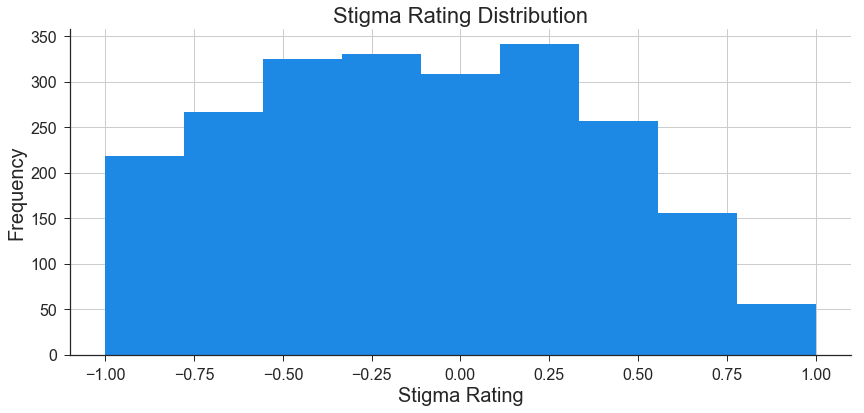

In [30]:
combined_df.stigma.hist(bins=9)
plt.title('Stigma Rating Distribution')
plt.xlabel('Stigma Rating')
plt.ylabel('Frequency')

It appears that the mean stigma is -0.122 and that overall, people are more likely to perceive stigma in the tech industry.

In [31]:
combined_df.stigma.mean()

-0.12245349867139062

## <i> Exploring Correlation of Other Features Towards Stigma </i>

### care_options 
#### <b>Do you know the options for mental health care available under your employer-provided coverage?</b>
For care options we decided to break down the responses to show where employees knew they had care options available to them, did not know or did not have them. This is a very subjective feature since we are trusting that the employees are aware of what options they have. The scale to show theses responses are from -1 to 1, where -1 represents having no care options available them and 1 representing they do. The graph shows that there is more stigma associated when there is no care options available to them. 

In [32]:
combined_df.loc[(combined_df.care_options == 'No'), 'care_options'] = -1
combined_df.loc[(combined_df.care_options == 'I am not sure') | (
    combined_df.care_options == 'Not sure') | (
    combined_df.care_options.isnull()), 'care_options'] = 0
combined_df.loc[(combined_df.care_options == 'Yes'), 'care_options'] = 1

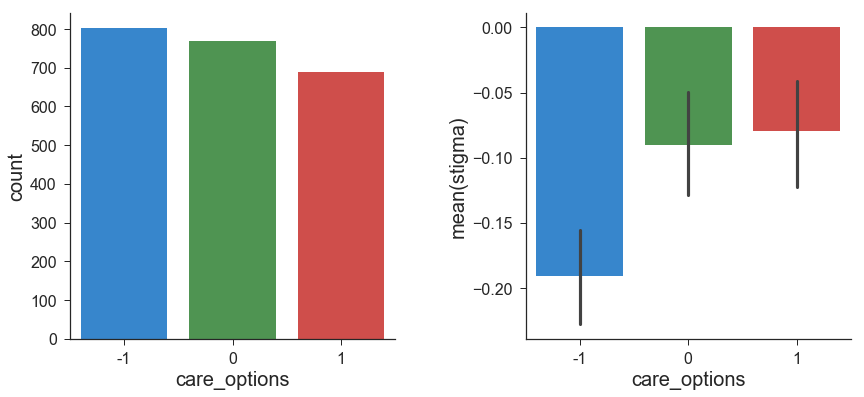

In [33]:
fig, (ax1, ax2) = plt.subplots(1, 2)
sns.countplot(x='care_options', data=combined_df, ax=ax1)
sns.barplot(x='care_options', y='stigma', data=combined_df, ax=ax2)

### wellness_program
#### Has your employer ever discussed mental health as part of an employee wellness program?
Similarly to the care options feature, the wellness program features asks if employers has ever talked to them (employees) about a wellness program. This feature helps us understand how open an employer is about programs that help the well being of employee, this could contribute to how feel about mental health. The responses were set on a scale of -1 to 1 where -1 meant employers did not talk about wellness programs and 1 meant that they did. 

In [34]:
combined_df.loc[(combined_df.wellness_program == 'No'), 'wellness_program'] = -1
combined_df.loc[(combined_df.wellness_program == 'I don\'t know') | (
    combined_df.wellness_program == 'Don\'t know'), 'wellness_program'] = 0
combined_df.loc[(combined_df.wellness_program == 'Yes'), 'wellness_program'] = 1

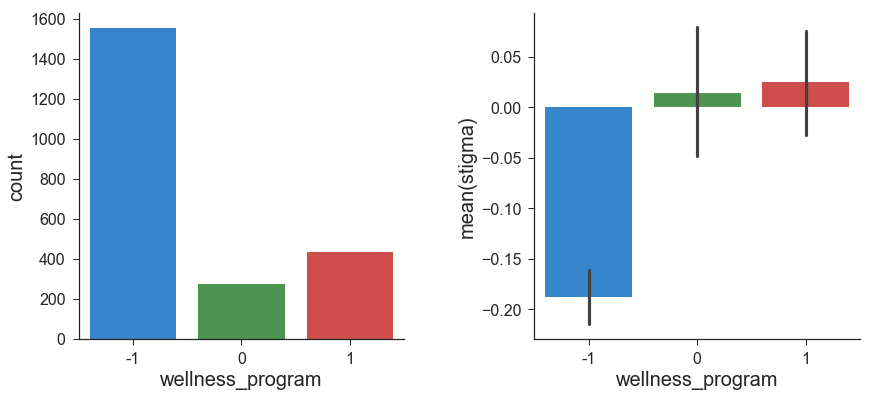

In [35]:
fig, (ax1, ax2) = plt.subplots(1, 2)
sns.countplot(x='wellness_program', data=combined_df, ax=ax1)
sns.barplot(x='wellness_program', y='stigma', data=combined_df, ax=ax2)

###  emp_help
#### Does your employer provide resources to learn more about mental health issues and how to seek help?
The employee help feature judges whether employers make employees aware of any mental health issues and seek help for them. This feature should help understand whether the support employers provide affect the employee idea and comfort level towards mental health.
The responses ranged from No, maybe and yes and were set on a scale from -1 to 1 respectively.  The graph shows that there is higher stigma associated with employees who are aware of the health there is associated with mental health issues. 


In [36]:
combined_df.loc[(combined_df.emp_help == 'No'), 'emp_help'] = -1
combined_df.loc[(combined_df.emp_help == 'I don\'t know') | (
    combined_df.emp_help == 'Don\'t know'), 'emp_help'] = 0
combined_df.loc[(combined_df.emp_help == 'Yes'), 'emp_help'] = 1

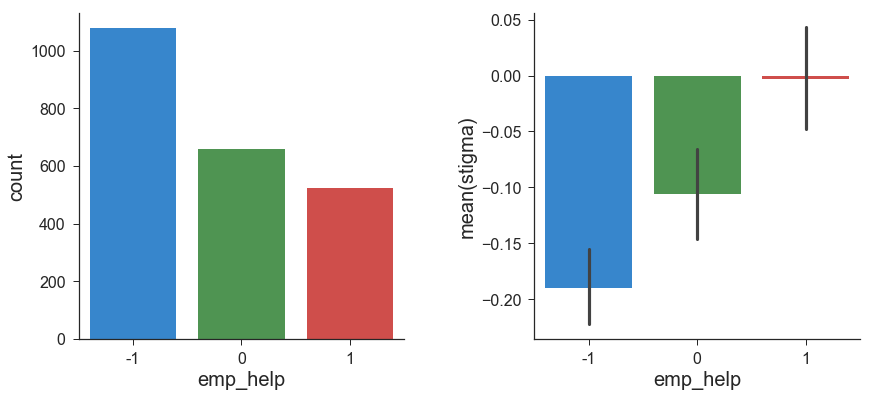

In [37]:
fig, (ax1, ax2) = plt.subplots(1, 2)
sns.countplot(x='emp_help', data=combined_df, ax=ax1)
sns.barplot(x='emp_help', y='stigma', data=combined_df, ax=ax2)

### *Resource Promotion Rating:
#### how active employers are in promoting mental health resources and awareness to employees
This feature was a compilation of the previous three features  - care options, wellness program and employee help. This features aims to show how active employees are in getting employee to learn about health care options and making them aware of the resources. The graph shows that the more employers promote resources the less mental health stigma employees have. 

In [38]:
combined_df['resource_promo'] = (combined_df.care_options + combined_df.wellness_program + combined_df.emp_help)
combined_df.stigma = combined_df.stigma.astype(float)

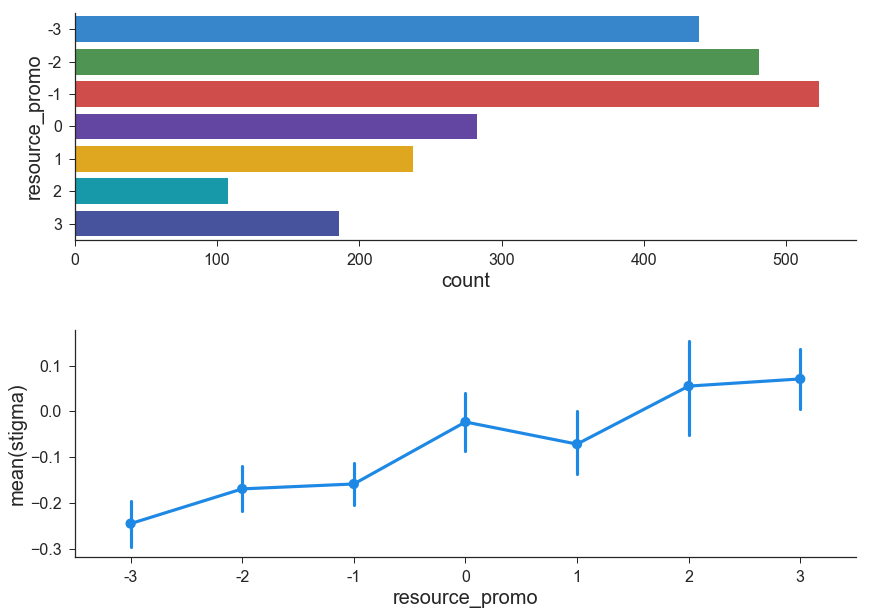

In [39]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14,10))
sns.countplot(y='resource_promo', data=combined_df, ax=ax1)
sns.pointplot(x='resource_promo', y='stigma', data=combined_df, ax=ax2)

#### date_submit: the timestamp of when the responder submits the form
This feature represents when the responses were submitted. When compared with stigma there seems to be more correlation. There were no time dependent patterns.

In [40]:
# string to datetime
combined_df.date_submit = pd.to_datetime(combined_df.date_submit)

In [41]:
# New features to see if there are any time dependent patterns
combined_df['year'] = combined_df.date_submit.dt.year
combined_df['month'] = combined_df.date_submit.dt.month
combined_df['week_day'] = combined_df.date_submit.dt.dayofweek # where 0 == Monday
combined_df['hour'] = combined_df.date_submit.dt.hour

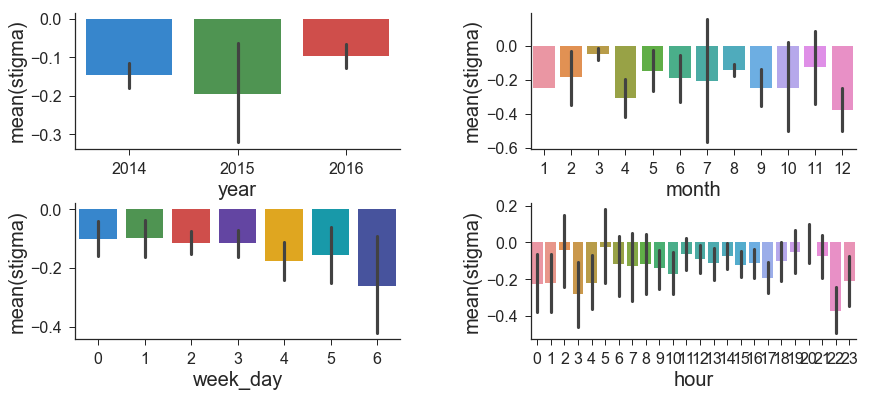

In [42]:
fig, ([ax1, ax2], [ax3, ax4]) = plt.subplots(2, 2)
sns.barplot(y='stigma', x='year', data=combined_df, ax=ax1)
sns.barplot(y='stigma', x='month', data=combined_df, ax=ax2)
sns.barplot(y='stigma', x='week_day', data=combined_df, ax=ax3)
sns.barplot(y='stigma', x='hour', data=combined_df, ax=ax4)

#### is_2016 

This feature shows how many respondents there were in the year 2016 compared to 2014. This could compare the overall stigma people had in each year. The observations are on scale of 0 to  1, where 0 is a year other than 2016 and 1 represents respondent from 2016. The graphs shows that there is more stigma associated the respondents in 2014 and 2015. 

In [43]:
combined_df.loc[(combined_df.year == 2016), 'year_2016'] = 1
combined_df.loc[(combined_df.year != 2016), 'year_2016'] = 0
combined_df.year_2016 = combined_df.year_2016.astype(int)

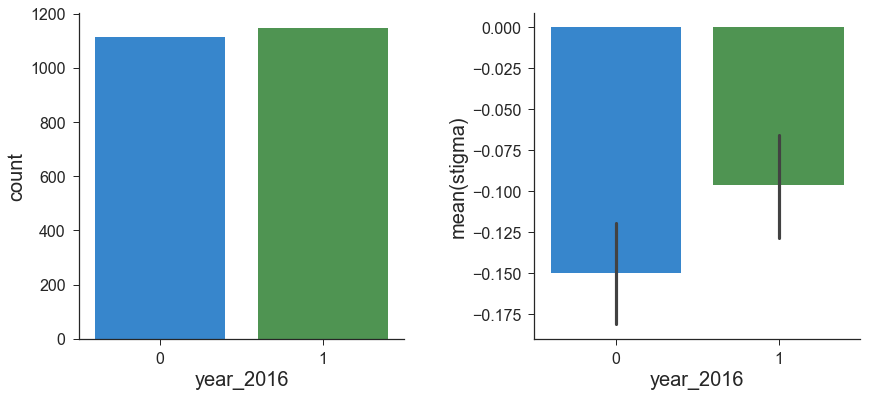

In [44]:
fig, (ax1, ax2) = plt.subplots(1, 2)
sns.countplot(x='year_2016', data=combined_df, ax=ax1)
sns.barplot(x='year_2016', y='stigma', data=combined_df, ax=ax2)

### age
For age, we decided to separate ages from 17 to 90 and did not include outliers or ages above or below 90. From our graph we see that the most employees fall in a range from 20-40 years of age. In the graph that compares stigma with age, we see that there is no obvious patterns or trends. There seems to be less stigma when people are above 60 years, but it is not significant. 

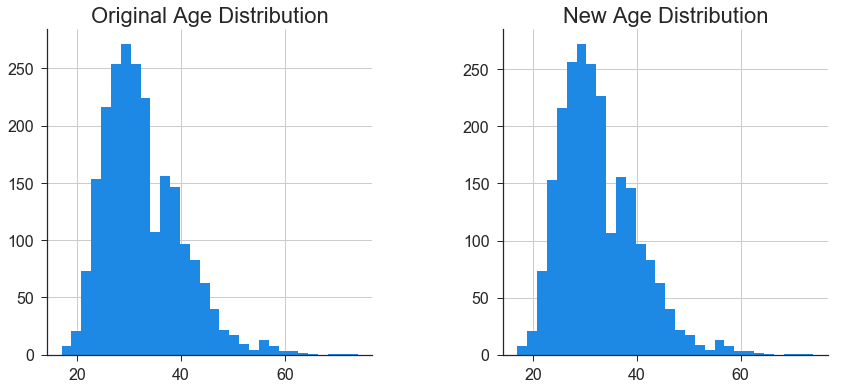

In [45]:
fig, (axis1, axis2) = plt.subplots(1, 2)
axis1.set_title('Original Age Distribution')
axis2.set_title('New Age Distribution')

# get median, Q1, Q3, and number of outlier ages
typical_ages = combined_df.loc[(combined_df.age >= 17) & (combined_df.age <= 90), 'age']
outlier_ages = combined_df.loc[(combined_df.age > 90) | (combined_df.age < 17), 'age']
median_age = typical_ages.median()
q1_age = typical_ages.quantile(0.25)
q3_age = typical_ages.quantile(0.75)
num_outlier_ages = len(outlier_ages)

# generate random ages between 1st and 3rd quantiles
new_ages = np.random.randint(q1_age, q3_age, size=num_outlier_ages)

# plot orig age distrib without the outliers
typical_ages.hist(bins=30, ax=axis1)

# fill outlier ages with new values
combined_df.loc[(combined_df.age > 90) | (combined_df.age < 17), 'age'] = new_ages
combined_df.age = combined_df.age.astype(int)

# plot age distribution with new values
combined_df.age.hist(bins=30, ax=axis2)

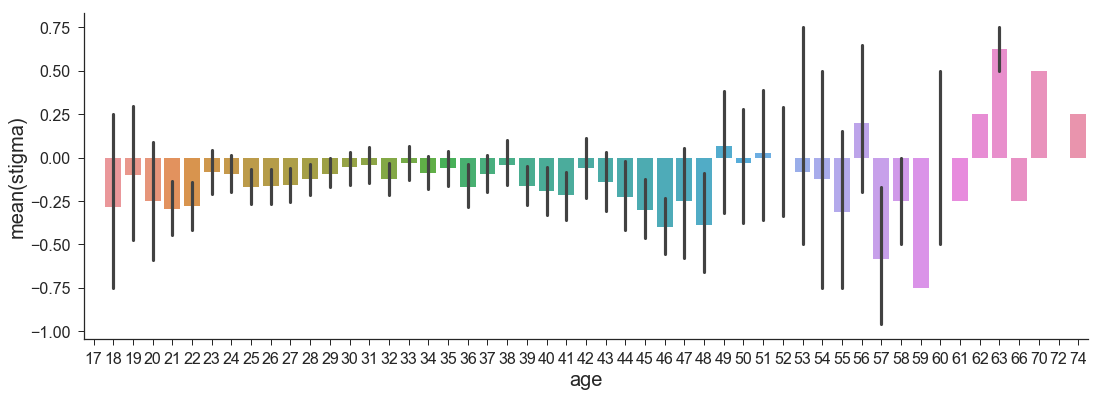

In [46]:
fig, ax = plt.subplots(1, 1, figsize=(18,6))
sns.barplot(x='age', y='stigma', data=combined_df)

### gender
The gender features separated respondents by male, female and other,  They are represented on scale of -1 to 1 where -1 is make, 0 is other and 1 is female. When graphed results with mean stigma we see that more stigma is associated with females. 
 
In order to include this feature in our analysis we combined female and other into one group to create the is male feature. 


In [47]:
# Separate all the unique responses into male, female, and other
all_gender = list(combined_df.gender.unique())
condit_female = ['Female', 'female', 'F', 'f', 'Femake', 'woman', 'Female ', 'Woman', 'femail',
                'I identify as female.', 'fm', 'female/woman', 'female ', 'fem',
                'Female (props for making this a freeform field, though)', ' Female']
condit_male = ['M', 'Male', 'male', 'maile', 'm', 'Make', 'Male ', 'Man', 'msle', 'Mail', 'Malr', 'man', 'Male.',
              'Sex is male', 'Dude', 'mail', 'male ']
condit_other = [i for i in all_gender if (i not in condit_male) and (i not in condit_female)] 

In [48]:
# Relabel according to each category
combined_df.loc[(combined_df.gender.isin(condit_male)), 'gender'] = -1
combined_df.loc[(combined_df.gender.isin(condit_other)), 'gender'] = 0
combined_df.loc[(combined_df.gender.isin(condit_female)), 'gender'] = 1

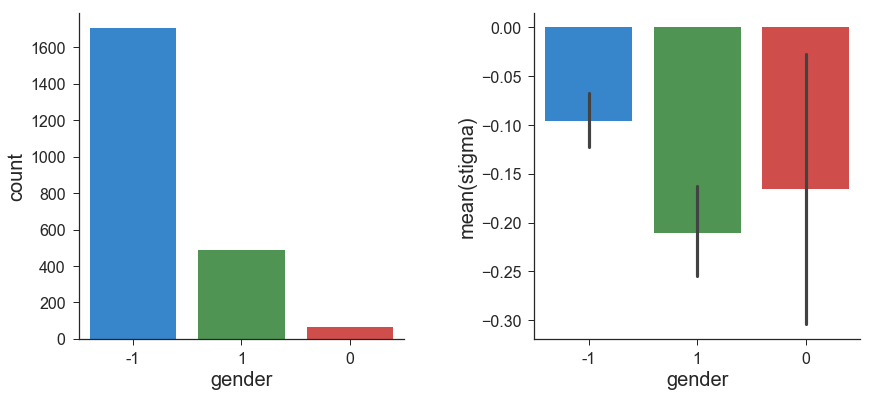

In [49]:
# plot counts for each gender
fig, (ax1, ax2) = plt.subplots(1, 2)
sns.countplot(x='gender', data=combined_df, ax=ax1, order=combined_df.gender.value_counts().index)
sns.barplot(x='gender', y='stigma', data=combined_df, ax=ax2, order=combined_df.gender.value_counts().index)

In [50]:
combined_df.loc[(combined_df.gender == -1), 'is_male'] = 1
combined_df.loc[(combined_df.gender != -1), 'is_male'] = 0
combined_df.is_male = combined_df.is_male.astype(int)

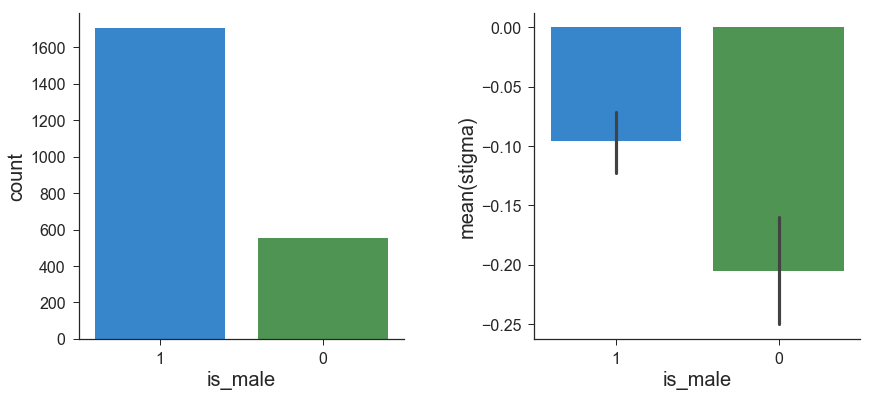

In [51]:
fig, (ax1, ax2) = plt.subplots(1, 2)
sns.countplot(x='is_male', data=combined_df, ax=ax1, order=combined_df.is_male.value_counts().index)
sns.barplot(x='is_male', y='stigma', data=combined_df, ax=ax2, order=combined_df.is_male.value_counts().index)

### *Location: splits USA into component states + other world countries
The location feature splits responses from the united states into their own states and keeps the other countries. This feature would help see how eat state in the US compares to other counties in the world. The graph shows the top location that responses came from and shows the stigma associated with it. There seems to be no trend, it shows that Michigan is the only one that has less stigma associated with it while Washington has the most. 

In [52]:
# Put together the USA & US responses
combined_df.loc[(combined_df.country_live == 'United States of America'), 'country_live'] = 'United States'

In [53]:
# Set state_live = NaN for non USA countries
combined_df.loc[(
    combined_df.state_live.notnull()) & (
    combined_df.country_live != 'United States'), 'state_live'] = np.nan

In [54]:
# Set state_live = the mode (California) for USA responses with NaN state_live
combined_df.loc[(
    combined_df.state_live.isnull()) & (
    combined_df.country_live == 'United States'), 'state_live'] = 'California'

In [55]:
# Convert abbrev. state_live responses to full name
state_abbr_full = {'IL': 'Illinois', 'IN': 'Indiana', 'TX': 'Texas', 'TN': 'Tennessee', 'MI': 'Michigan',
                  'OH': 'Ohio', 'CA': 'California', 'CT': 'Connecticut', 'NY': 'New York', 'MA': 'Massachusetts',
                  'IA': 'Iowa', 'WA': 'Washington', 'WI': 'Wisconsin', 'UT': 'Utah', 'NM': 'New Mexico',
                  'OR': 'Oregon', 'FL': 'Florida', 'MN': 'Minnesota', 'MO': 'Missouri', 'AZ': 'Arizona',
                  'CO': 'Colorado', 'GA': 'Georgia', 'DC': 'District of Columbia', 'NE': 'Nebraska',
                  'MD': 'Maryland', 'PA': 'Pennsylvania', 'WV': 'West Virginia', 'OK': 'Oklahoma',
                  'NC': 'North Carolina', 'KS': 'Kansas', 'VA': 'Virginia', 'NH': 'New Hampshire', 'KY': 'Kentucky',
                  'AL': 'Alabama', 'NV': 'Nevada', 'NJ': 'New Jersey', 'SC': 'South Carolina', 'VT': 'Vermont',
                  'SD': 'South Dakota', 'ID': 'Idaho', 'RI': 'Rhode Island', 'WY': 'Wyoming', 'LA': 'Louisiana',
                  'ME': 'Maine', 'AK': 'Alaska', 'AR': 'Arkansas', 'DE': 'Delaware', 'HI': 'Hawaii',
                  'MS': 'Mississippi', 'MT': 'Montana', 'ND': 'North Dakota'}
combined_df.loc[(combined_df.state_live.str.len() == 2), 'state_live'] = combined_df.loc[(combined_df.state_live.str.len() == 2), 'state_live'].map(state_abbr_full)

In [56]:
# Create feature 'location' that splits USA by states and considers them on same level as other countries
combined_df['location'] = combined_df.country_live
combined_df.loc[(
    combined_df.state_live.notnull()) & (
    combined_df.country_live == 'United States'), 'location'] = combined_df.state_live

In [57]:
loc_counts = combined_df.location.value_counts()[:10]
loc_stig = combined_df[['location', 'stigma']].groupby('location', as_index=False).mean()
loc_stig.drop(loc_stig[(~loc_stig.location.isin(loc_counts.index))].index, axis=0, inplace=True)

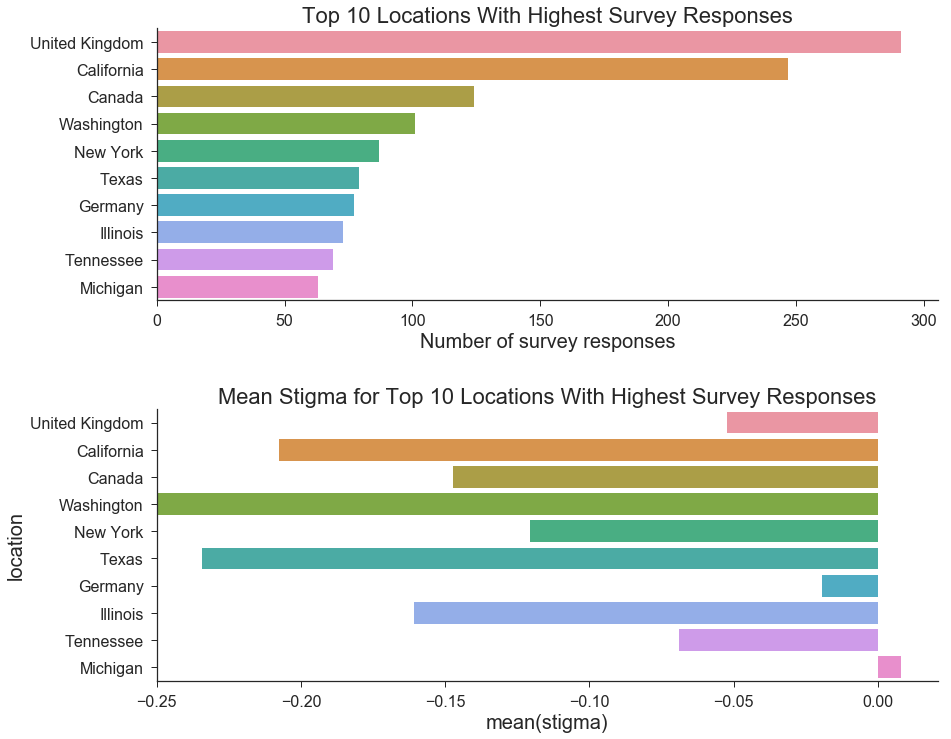

In [58]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12))
sns.barplot(y=loc_counts.index, x=loc_counts.values, ax=ax1)
ax1.set_title('Top 10 Locations With Highest Survey Responses')
ax1.set_xlabel('Number of survey responses')
sns.barplot(y=loc_stig.location, x=loc_stig.stigma, ax=ax2, order=loc_counts.index)
ax2.set_title('Mean Stigma for Top 10 Locations With Highest Survey Responses')

### *Continent
The continent feature aggregates all the responses and associates them with the corresponding continent to then take a look at how each continent compares with each other in terms of responses and stigma rating. The graph shows there were more respondents from North American and people from South America have more stigma. 

In [59]:
# get country to continent mapping and add as new feature
geo_cc = pd.Series(geo_divs.set_index('country').continent)
continent = combined_df.country_live.map(geo_cc)
combined_df['continent'] = continent

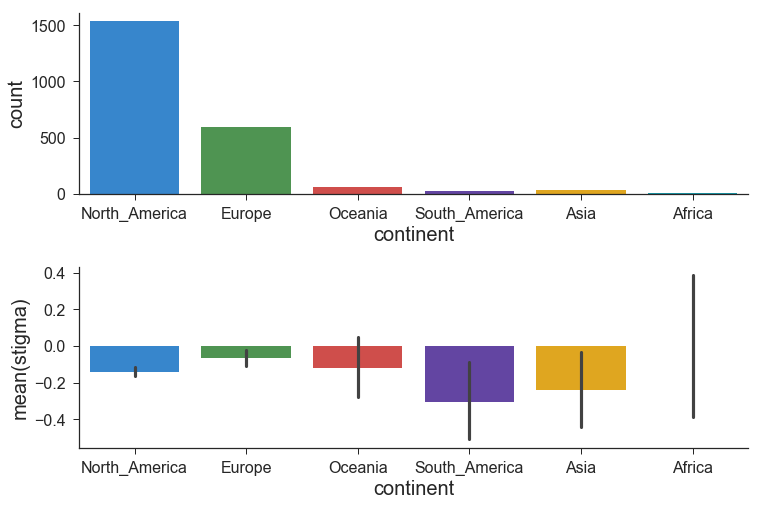

In [60]:
# plot counts
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,8))
sns.countplot(x='continent', data=combined_df, ax=ax1)
sns.barplot(x='continent', y='stigma', data=combined_df, ax=ax2)

#### *United States vs United Kingdom vs All Other Countries 
This features separates responses from the United States, United Kingdom and other responses. The reason for doing this is because there was the most respondents from the united states and from the united kingdom. Based on the graph we see that there is the most stigma associated with people working in the United States.

In [61]:
combined_df.loc[((combined_df.country_live != 'United States') & (combined_df.country_live != 'United Kingdom'), 'us_uk_other')] = 'Other'
combined_df.loc[((combined_df.country_live == 'United States'), 'us_uk_other')] = 'US'
combined_df.loc[((combined_df.country_live == 'United Kingdom'), 'us_uk_other')] = 'UK'
us_uk_other_dummies = pd.get_dummies(combined_df.us_uk_other, prefix='country', drop_first=True)
combined_df = combined_df.join(us_uk_other_dummies)

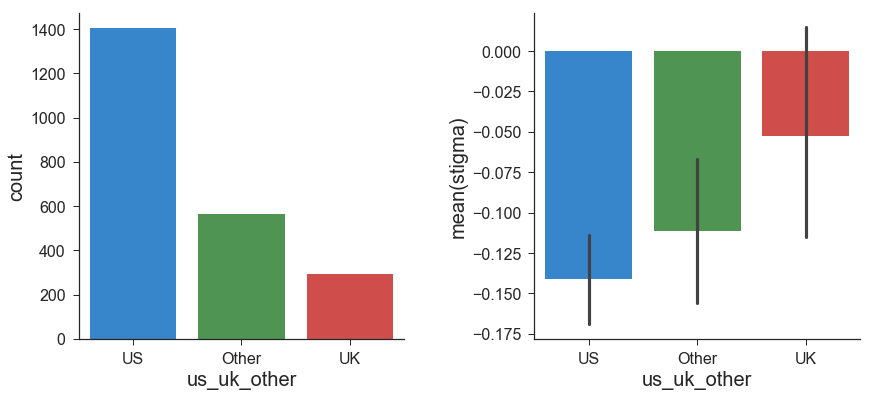

In [62]:
fig, (ax1, ax2) = plt.subplots(1, 2)
sns.countplot(x='us_uk_other', data=combined_df, ax=ax1)
sns.barplot(x='us_uk_other', y='stigma', data=combined_df, ax=ax2)

### *Europe vs All Other Countries
This separates Europe from all other countries to see how they rate in terms of stigma. Europe is represented with a 1 and other countries are represented by a 0. The graph shows that there is more stigma associated with employees in Europe compared to to other countries. 

In [63]:
combined_df.loc[(combined_df.continent == 'Europe'), 'is_europe'] = 1
combined_df.loc[(combined_df.continent != 'Europe'), 'is_europe'] = 0
combined_df.is_europe = combined_df.is_europe.astype(int)

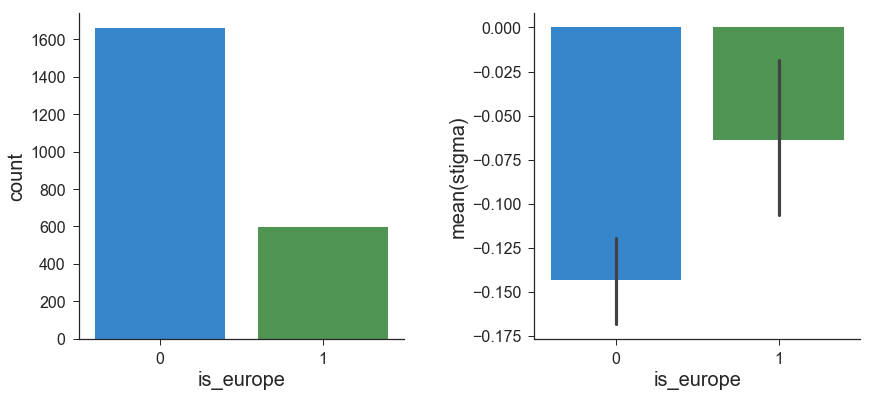

In [64]:
fig, (ax1, ax2) = plt.subplots(1, 2)
sns.countplot(x='is_europe', data=combined_df, ax=ax1)
sns.barplot(x='is_europe', y='stigma', data=combined_df, ax=ax2)

### *USA States (with >20 survey responses)
In order to take a closer look at how the united states deals with stima we decided to get the top states that received more than 20 responses. We then used this information to create a geospatial map of the United States to show based on color which states have more stigma. The darker the shade of the state the less mental health stigma they have. There seems to be no trend in terms of having more stigma in a certain region. The map shows the two states with the least stigma are in the north eastern part of the United States. We would have gotten better results if we had a larger database with more responses from each state. 

In [65]:
state_stig = pd.DataFrame()
fol_states = []
fol_stigs = []

loop_states = combined_df.state_live.dropna().unique()
for state in loop_states:
    # Don't include states with fewer than 20 survey responses
    if len(combined_df.loc[(combined_df.state_live == state)]) > 20:
        ave_stig = combined_df.loc[(combined_df.state_live == state), 'stigma'].mean()
        fol_stigs.append(ave_stig)
        fol_states.append(state)
        
fol_states = pd.Series(fol_states)
fol_stigs = pd.Series(fol_stigs)

state_stig['state'] = fol_states
state_stig['stigma'] = fol_stigs

In [66]:
states_to_abbrev = {b:a for a,b in state_abbr_full.items()}
state_stig.state = state_stig.state.replace(states_to_abbrev)

In [67]:
overlays = pd.read_json('data/us-states.json')

In [68]:
for ind, val in overlays.features.iteritems():
    if val['id'] not in state_stig.state.values:
        overlays.drop(ind, axis=0, inplace=True)

In [69]:
header = '{"type": "FeatureCollection", "features": '
footer = '}'
new_overlays = header + str(overlays.features.values).replace("'", '"').replace("\n", ',') + footer

In [70]:
with open('data/new_overlays2.json', 'w') as f:
    f.seek(0)
    f.write(new_overlays)
    f.truncate()

In [71]:
m = folium.Map([43, -100], zoom_start=4)
m.choropleth(geo_path='data/new_overlays2.json',
             data=state_stig,
             columns=['state', 'stigma'],
             key_on='feature.id',
             fill_color='YlOrRd', legend_name='stigma', highlight=True)
m

<img src='choropleth_states.png'>

### family_history
#### Do you have a family history of mental illness?
The family history features took responses from question asking employees if they knew of any family history relating to mental health. The responses were put on a scale of -1 to 0, -1 represent  “No”, 0 represents “Maybe” and 1 represented “Yes” . The graphs shows that people that responded with  maybe have more stigma. This could be because they are less willing to give up that information. 

In [72]:
# Relabel
combined_df.loc[(combined_df.family_history == 'No'), 'family_history'] = -1
combined_df.loc[(combined_df.family_history == 'I don\'t know'), 'family_history'] = 0
combined_df.loc[(combined_df.family_history == 'Yes'), 'family_history'] = 1

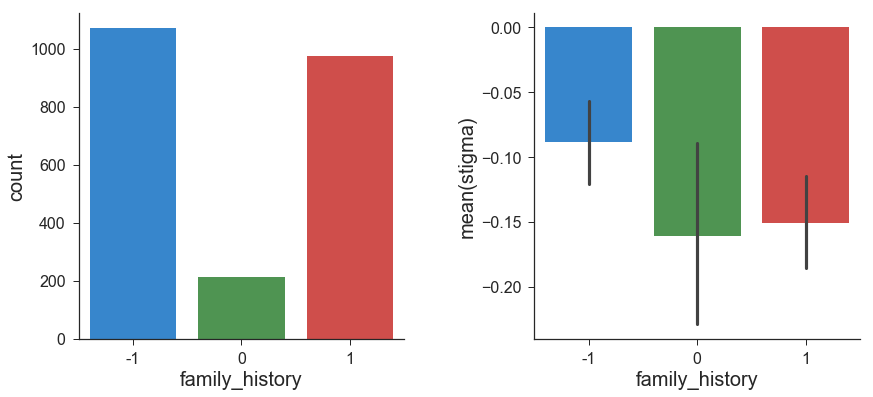

In [73]:
# plot counts
fig, (ax1, ax2) = plt.subplots(1, 2)
order = [-1, 0, 1]
sns.countplot(x='family_history', data=combined_df, ax=ax1, order=order)
sns.barplot(x='family_history', y='stigma', data=combined_df, ax=ax2, order=order)

### work_interfere
#### If you have a mental health condition, do you feel that it interferes with your work?
This questions evaluates individuals opinions on whether or not they believe that having a mental health condition interferes with their work commitments. The responses range from “never”, “rarely”, “sometimes”, and “often. The most responses can be seen in individuals who responded with sometimes, which is also the ones who have the most stigma. Additionally, the greatest level of stigma can be seen in individuals who responded with “often”. 

In [74]:
# Lump 'Not applicable to me' with NaN
combined_df.loc[combined_df.work_interfere == 'Not applicable to me', 'work_interfere'] = np.nan

In [75]:
# According to OSMI Survey: 
# 'This survey is for everyone working in tech, not just those who have a mental health issue.'
# Assumption: IF work_interfere == N/A THEN treatment == 0 AND has_illness = 0
combined_df.loc[(combined_df.work_interfere.isnull()), 'treatment'] = 0

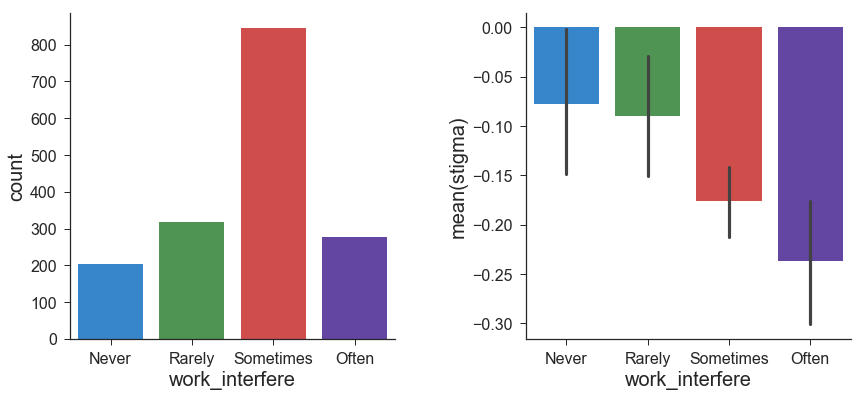

In [76]:
# plot counts
fig, (ax1, ax2) = plt.subplots(1, 2)
order = ['Never', 'Rarely', 'Sometimes', 'Often']
sns.countplot(x='work_interfere', data=combined_df, ax=ax1, order=order)
sns.barplot(x='work_interfere', y='stigma', data=combined_df, ax=ax2, order=order)

### treatment
#### Have you sought treatment for a mental health condition?
 When individuals were asked if they had seeked help for a mental health condition the responses to both “yes” (1) and “no” (0) were very similar. Both of the responses were associated with different levels stigma. However, those individuals who had seeked help had the highest level of stigma.

In [77]:
# Relabel yes = 1, no = 0
combined_df.loc[(combined_df.treatment == 'No') | (combined_df.treatment == 0), 'treatment'] = 0
combined_df.loc[(combined_df.treatment == 'Yes'), 'treatment'] = 1

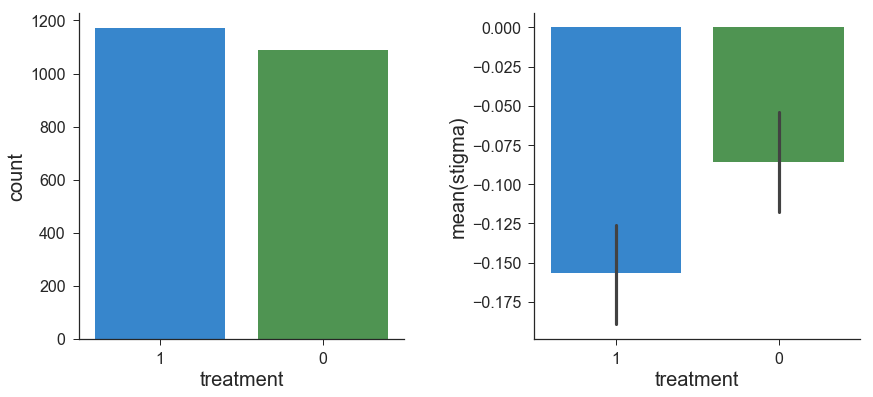

In [78]:
# plot counts
fig, (ax1, ax2) = plt.subplots(1, 2)
sns.countplot(x='treatment', data=combined_df, ax=ax1, order=combined_df.treatment.value_counts().index)
sns.barplot(x='treatment', y='stigma', data=combined_df, ax=ax2, order=combined_df.treatment.value_counts().index)

### num_employees
#### How many employees does your company or organization have?
The number of employees in a given company were divided into the ranges of 1-5, 6-25, 26-100, 100-500, and 1000+. All the ranges demonstrated with some level of stigma with the greatest value seen in companies that had 1000 or more employees this could be realted to the size of the company . 

In [79]:
combined_df.loc[(combined_df.num_employees == 'More than 1000'), 'num_employees'] = '1000+'

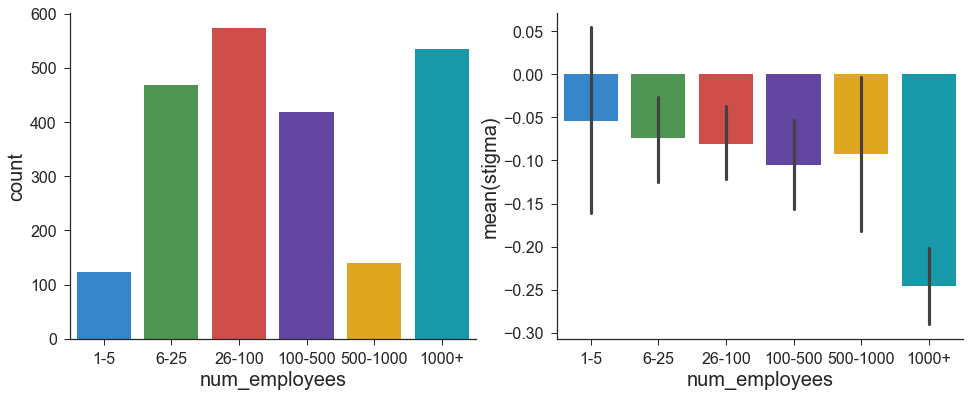

In [80]:
# plot counts
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))
fig.subplots_adjust(wspace=0.2)
sns.countplot(x='num_employees', data=combined_df, ax=ax1, order=['1-5', '6-25', '26-100', '100-500', '500-1000', '1000+'])
sns.barplot(x='num_employees', y='stigma', data=combined_df, ax=ax2, order=['1-5', '6-25', '26-100', '100-500', '500-1000', '1000+'])

In [81]:
combined_df.loc[(combined_df.num_employees == '1000+'), 'big_company'] = 1
combined_df.loc[(combined_df.num_employees != '1000+'), 'big_company'] = 0
combined_df.big_company = combined_df.big_company.astype(int)

### remote
#### Do you work remotely (outside of an office) at least 50% of the time?
When asking individuals whether or not they worked in remotely or not in an office at least 50% of the time, the majority responded with no they did not (associated with -1). The bar graph also shows they are the individuals who also the greatest amount stigma. Those who answered that they sometimes work remotely and those who did work remotely (0 and 1 respectively) also showed small levels of stigma. 

In [82]:
combined_df.loc[(combined_df.remote == 'No') | (combined_df.remote == 'Never'), 'remote'] = -1
combined_df.loc[(combined_df.remote == 'Sometimes'), 'remote'] = 0
combined_df.loc[(combined_df.remote == 'Yes') | (combined_df.remote == 'Always'), 'remote'] = 1

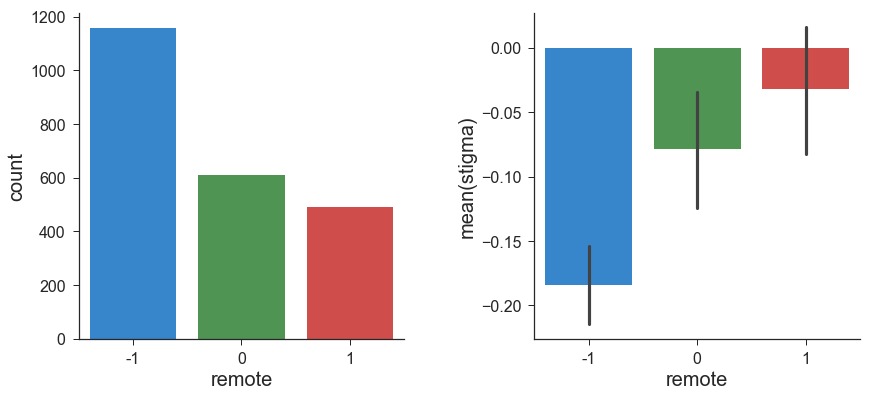

In [83]:
# plot counts
fig, (ax1, ax2) = plt.subplots(1, 2)
sns.countplot(x='remote', data=combined_df, ax=ax1)
sns.barplot(x='remote', y='stigma', data=combined_df, ax=ax2)

### tech_comp
#### Is your employer primarily a tech company/organization?
This questions makes a distinction between individuals who work in a tech company or organizations and those who don’t. In this case, those who respond to no are associated with 0 and those who do are associated with 1. The majority of the individuals who responded to woking in a tech company but had less stigma when compared to those who did not work in a tech company, as they had a greater amount of stigma. 


In [84]:
combined_df.loc[(combined_df.tech_comp == 'No') | (combined_df.tech_comp == 0), 'tech_comp'] = 0
combined_df.loc[(combined_df.tech_comp == 'Yes'), 'tech_comp'] = 1

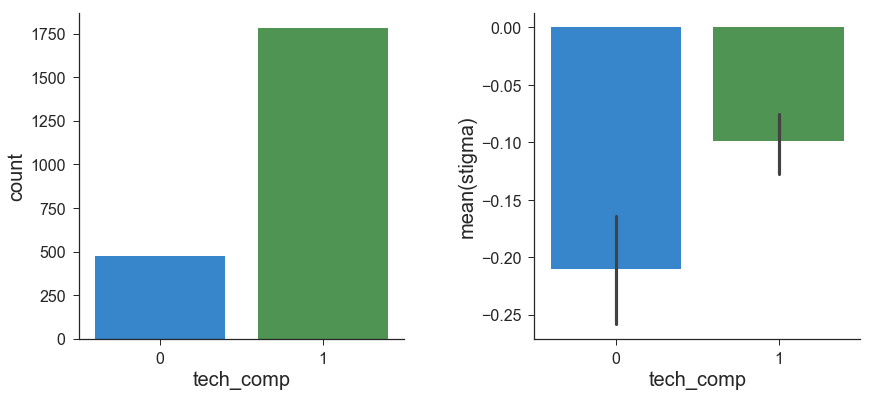

In [85]:
# plot counts
fig, (ax1, ax2) = plt.subplots(1, 2)
sns.countplot(x='tech_comp', data=combined_df, ax=ax1)
sns.barplot(x='tech_comp', y='stigma', data=combined_df, ax=ax2)

### benefits
#### Does your employer provide mental health benefits?
This question addresses whether mental health benefits are provided by employer. The answers  range from “no”, “not eligible or don’t know”, and “yes”. These responses are associated with -1, 0, and 1 respectively. The majority of responses were associated with yes showing that benefits for mental health are provided and the least amount of responses were associated with no or not having benefits. However, all the responses have stigma levels. 

In [86]:
combined_df.loc[(combined_df.benefits == 'No') | (
    combined_df.benefits == 'Not eligible for coverage / N/A'), 'benefits'] = -1
combined_df.loc[(combined_df.benefits == 'I don\'t know') | (
    combined_df.benefits == 'Don\'t know'), 'benefits'] = 0
combined_df.loc[(combined_df.benefits == 'Yes'), 'benefits'] = 1

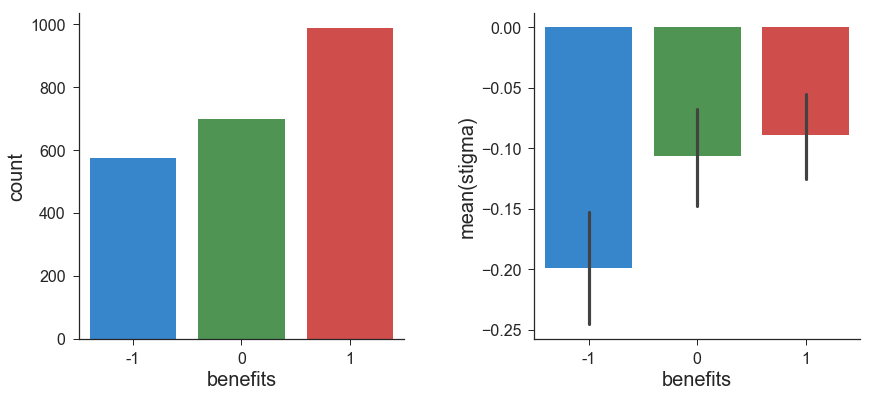

In [87]:
# plot counts
fig, (ax1, ax2) = plt.subplots(1, 2)
sns.countplot(x='benefits', data=combined_df, ax=ax1)
sns.barplot(x='benefits', y='stigma', data=combined_df, ax=ax2)

### anon
#### Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources? 
Anonymity refers to whether individuals identity can be kept confidential if they seek help for a mental health condition. The responses “No”, “I don’t know”, and “Yes” are associated with -1, 0 , and 1 respectively. Those individuals whose anonymity is not kept demonstrate a higher level of stigma than compared to those whose identity is not shared. 

In [88]:
combined_df.loc[(combined_df.anon == 'No'), 'anon'] = -1
combined_df.loc[(combined_df.anon == 'I don\'t know') | (
    combined_df.anon == 'Don\'t know'), 'anon'] = 0
combined_df.loc[(combined_df.anon == 'Yes'), 'anon'] = 1

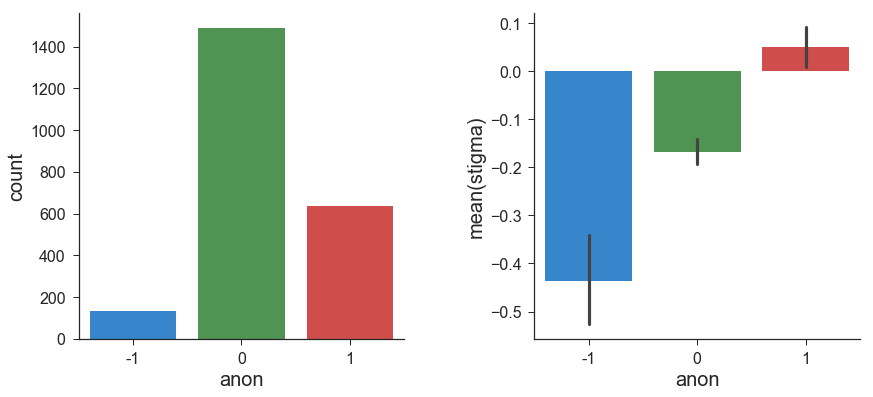

In [89]:
# plot counts
fig, (ax1, ax2) = plt.subplots(1, 2)
sns.countplot(x='anon', data=combined_df, ax=ax1)
sns.barplot(x='anon', y='stigma', data=combined_df, ax=ax2)

### med_leave
#### How easy is it for you to take medical leave for a mental health condition?
This questions addresses the level of difficulty that exists when an employee requests medical leave for a mental health condition. The bar graph on the right shows that when it is harder to have medical leave, there is also a greater amount of stigma. This is also seen in the range from hard to medium difficulty when requesting medical leave. In addition, the majority of individuals do not know the level of difficulty in regards to requesting medical leave. 

In [90]:
# Relabel
combined_df.loc[(combined_df.med_leave == 'I don\'t know') | (
    combined_df.med_leave == 'Don\'t know'), 'med_leave'] = 'unknown'
combined_df.loc[(combined_df.med_leave == 'Very easy'), 'med_leave'] = 'hi_easy'
combined_df.loc[(combined_df.med_leave == 'Somewhat easy'), 'med_leave'] = 'lo_easy'
combined_df.loc[(combined_df.med_leave == 'Neither easy nor difficult'), 'med_leave'] = 'med'
combined_df.loc[(combined_df.med_leave == 'Somewhat difficult'), 'med_leave'] = 'lo_hard'
combined_df.loc[(combined_df.med_leave == 'Very difficult'), 'med_leave'] = 'hi_hard'

In [91]:
# One-Hot Encode
med_leave_dummies = pd.get_dummies(combined_df.med_leave, prefix='mleave', drop_first=True)
combined_df = combined_df.join(med_leave_dummies)

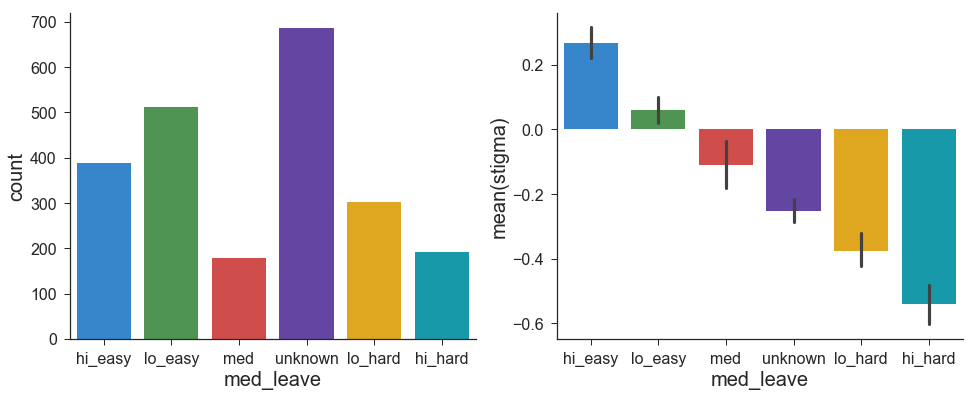

In [92]:
# plot counts
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(wspace=0.2)
med_leave_order = ['hi_easy', 'lo_easy', 'med', 'unknown', 'lo_hard', 'hi_hard']
sns.countplot(x='med_leave', data=combined_df, ax=ax1, order=med_leave_order)
sns.barplot(x='med_leave', y='stigma', data=combined_df, ax=ax2, order=med_leave_order)

### obs_conseq
#### Have you heard of or observed negative consequences for coworkers with mental health conditions in your workplace?
This questions refers to individuals who have observed or heard of a negative response to another co-worker that has mental health condition. In this case, 0 is associated with no they did not observe or hear of negative consequences. The value of 1 is associated with individuals who have heard or observed negative consequences. To conclude, there are stigma for both conditions but there is a greater value of stigma to those individuals who said yes. This can mean that people will not be willing to talk about mental health if they are in a workplace that is not accepting of mental health conditions

In [93]:
combined_df.loc[(combined_df.obs_conseq == 'No') | (combined_df.obs_conseq == 0), 'obs_conseq'] = 0
combined_df.loc[(combined_df.obs_conseq == 'Yes'), 'obs_conseq'] = 1

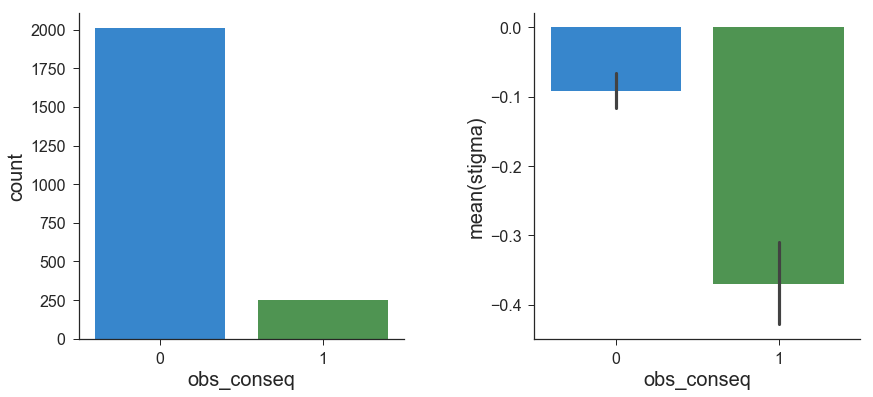

In [94]:
# plot counts
fig, (ax1, ax2) = plt.subplots(1, 2)
sns.countplot(x='obs_conseq', data=combined_df, ax=ax1)
sns.barplot(x='obs_conseq', y='stigma', data=combined_df, ax=ax2)

In [95]:
combined_df.head()

,date_submit,num_employees,tech_comp,benefits,care_options,wellness_program,emp_help,anon,med_leave,ment_conseq,coworkers,supervisors,obs_conseq,ment_interv,family_history,treatment,age,gender,country_live,state_live,remote,work_interfere,stigma,general_stigma,resource_promo,year,month,week_day,hour,year_2016,is_male,location,continent,us_uk_other,country_UK,country_US,is_europe,big_company,mleave_hi_hard,mleave_lo_easy,mleave_lo_hard,mleave_med,mleave_unknown
0,2014-08-27 11:29:31,6-25,1,1,0,-1,1,1,lo_easy,1,0,1,0,-1,-1,1,37,1,United States,Illinois,-1,Often,0.25,1,0,2014,8,2,11,0,0,Illinois,North_America,US,0,1,0,0,0,1,0,0,0
1,2014-08-27 11:29:37,1000+,0,0,-1,0,0,0,unknown,0,-1,-1,0,-1,-1,0,44,-1,United States,Indiana,-1,Rarely,-0.75,0,-1,2014,8,2,11,0,1,Indiana,North_America,US,0,1,0,1,0,0,0,0,1
2,2014-08-27 11:29:44,6-25,1,-1,-1,-1,-1,0,lo_hard,1,1,1,0,1,-1,0,32,-1,Canada,NaN,-1,Rarely,1.00,1,-3,2014,8,2,11,0,1,Canada,North_America,Other,0,0,0,0,0,0,1,0,0
3,2014-08-27 11:29:46,26-100,1,-1,1,-1,-1,-1,lo_hard,-1,0,-1,1,0,1,1,31,-1,United Kingdom,NaN,-1,Often,-0.50,0,-1,2014,8,2,11,0,1,United Kingdom,Europe,UK,1,0,1,0,0,0,1,0,0
4,2014-08-27 11:30:22,100-500,1,1,-1,0,0,0,unknown,1,0,1,0,1,-1,0,31,-1,United States,Texas,1,Never,0.75,1,-1,2014,8,2,11,0,1,Texas,North_America,US,0,1,0,0,0,0,0,0,1


## <i>Data Modeling and Analysis</i>

### Key Features 
We identified the features below as the ones we wanted to further explore and correlate with levels of stigma. These features were chosen because they could have the most value and insight regarding our research question. 

In [96]:
# Key Feature Selection
model_df = combined_df[[
    'year_2016', 'is_male', 'treatment', 'benefits', 'care_options', 'wellness_program', 'emp_help',
    'anon', 'obs_conseq', 'is_europe', 'big_company', 'remote', 'tech_comp',
    'mleave_hi_hard', 'mleave_lo_hard', 'mleave_unknown', 'mleave_med', 'mleave_lo_easy', 'general_stigma', 'country_US', 'country_UK']]

In [97]:
model_df.head()

,year_2016,is_male,treatment,benefits,care_options,wellness_program,emp_help,anon,obs_conseq,is_europe,big_company,remote,tech_comp,mleave_hi_hard,mleave_lo_hard,mleave_unknown,mleave_med,mleave_lo_easy,general_stigma,country_US,country_UK
0,0,0,1,1,0,-1,1,1,0,0,0,-1,1,0,0,0,0,1,1,1,0
1,0,1,0,0,-1,0,0,0,0,0,1,-1,0,0,0,1,0,0,0,1,0
2,0,1,0,-1,-1,-1,-1,0,0,0,0,-1,1,0,1,0,0,0,1,0,0
3,0,1,1,-1,1,-1,-1,-1,1,1,0,-1,1,0,1,0,0,0,0,0,1
4,0,1,0,1,-1,0,0,0,0,0,0,1,1,0,0,1,0,0,1,1,0


In [98]:
model_df.big_company.unique()

array([0, 1])

In [99]:
X = model_df.drop('general_stigma', axis=1).astype(int)
Y = model_df.general_stigma.astype(int)

In [100]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)

In [101]:
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((1580, 20), (1580,), (678, 20), (678,))

In [102]:
# Train random forest classifier
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False)

In [103]:
# Make predictions on testing set
Y_pred = random_forest.predict(X_test)

In [104]:
# Evaluate performance
random_forest.score(X_train, Y_train), random_forest.score(X_test, Y_test)

(0.97341772151898731, 0.67994100294985249)

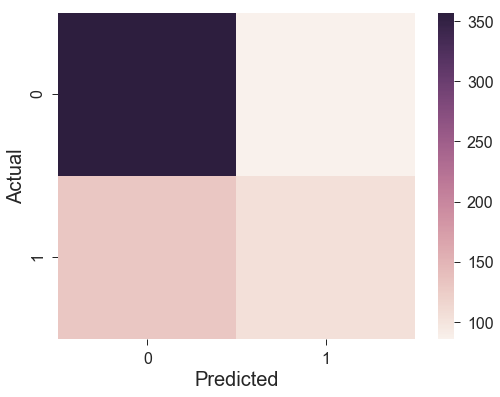

In [105]:
# Confusion matrix
conf_mat = pd.crosstab(Y_test, Y_pred, rownames=['Actual'], colnames=['Predicted'])
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(conf_mat, ax=ax)

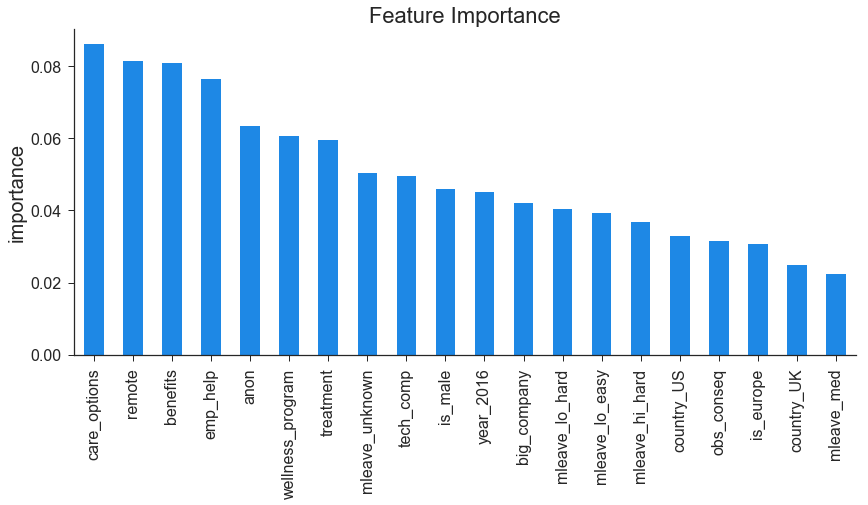

In [106]:
# Show the most important features
most_important = pd.DataFrame(
    random_forest.feature_importances_,
    columns=['importance'],
    index=X_train.columns).sort_values('importance', ascending=False)

fig, ax = plt.subplots(1, 1)
most_important.plot(kind='bar', ax=ax)
ax.set_title('Feature Importance')
ax.legend().remove()
ax.set_ylabel('importance')

## <i> Discussion </i>

According to the results of our data analysis our hypothesis was not supported. We predicted older people will be less comfortable discussing mental health issues as they age, but there was no correlation found between these two features. In contrast to our predicted claim of males having a greater mental health stigma, our results demonstrated a reverse effect. To our surprise, females exhibited greater mental health stigma compared to males, thus our hypothesis was not supported. One possible reason could be because our hypothesis was based on Chandra’s research on mental health stigma on gender of the general population, whereas our data is focused on employees from the Tech 

Further visualizations and analysis revealed insightful trends between variables that were not initially included in our hypothesis. We found that if an employer provides mental health benefits as part of healthcare coverage, there is less stigma reported. Although mental health resources available could greatly vary among workplace, the utilization of those resources is susceptible to the level of comfort. If anonymity is not protected while choosing to take advantage of mental health or substance abuse treatment resources, there was increased stigma. Similarly, the perception of mental health fluctuated depending on how easy or hard it was to ask for medical leave for a mental health condition. When employees found it difficult to request for medical leave, stigma was higher.

Moreover, the mere promotion of resources overall reduces mental health stigma of employees. The awareness of resources was composed of three quantifiable factors from our data. They include knowledge of mental health care options, employer’s willingness to discuss mental health as part of the wellness program, and if the employer resources to learn more about mental health issues and how to seek help. We clustered these features together because they are all dependent on the employer. 


## <i> Conclusion </i>

Our findings lead us to conclude employers in the tech industry largely influence mental health stigma of their employees despite popular perceptions of mental health as an individual and personal issue. While the data illustrated the tech industry has less overall mental health stigma, it is critical to point out that tech is the largest industry with opportunities to work remotely (Shin 2017). Therefore, the low stigma can be associated with the flexibility of work environment, given that working remotely from home shows less mental health stigma. 
 
The analysis of our data supports how the dynamics of the workplace and employer-employee relationships plays a big role in perceived mental health stigma. If companies want to reduce mental health stigma in their workplace, they should provide resources, promote those resources, and allow employees to work remotely.  


## <i> References </i>

Referencess (include a link):
- 1)Chandra, Anita, and Cynthia S. Minkovitz. "Stigma starts early: Gender differences in teen willingness to use mental health services." Journal of Adolescent Health 38.6 (2006): 754-e1.
http://www.sciencedirect.com/science/article/pii/S1054139X05003952
- 2)Corrigan, Patrick W., and Amy C. Watson. "Understanding the Impact of Stigma on People with Mental Illness." World Psychiatry. Masson Italy, Feb. 2002. Web. 19 May 2017. <https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1489832/>. 
- 3) Jang, Yuri, David A. Chiriboga, and Sumie Okazaki. "Attitudes toward mental health services: Age-group differences in Korean American adults." Aging and Mental Health 13.1 (2009): 127-134.
http://www.tandfonline.com/doi/abs/10.1080/13607860802591070 
- 4) Link, Bruce G., et al. "A modified labeling theory approach to mental disorders: An empirical assessment." American sociological review (1989): 400-423.
- 5) Phyllis, Gabriel, Marjo-Riitta Liimatainen, and International Labor Office. "Are You More Than Okay: The State of Mental Health in Tech in 2016." Cornell University DigitalCommons@ILR. GLADNET Collection, Jan. 2000. Web. 17 May 2017. <http://digitalcommons.ilr.cornell.edu/cgi/viewcontent.cgi?article=1224&context=gladnetcollect>.
- 6) Shin, Laura. "Work From Home In 2017: The Top 100 Companies Offering Remote Jobs."Forbes. Forbes Magazine, 02 Feb. 2017. Web. 10 June 2017. https://www.forbes.com/sites/laurashin/2017/01/31/work-from-home-in-2017-the-top-100-companies-offering-remote-jobs/#4299dfc442d8
